In [1]:
from sklearn.linear_model import LogisticRegression as lr
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import networkx as nx
from networkx.algorithms.tree.branchings import maximum_branching
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [5]:
def get_treatment_level(input):
    if input < 2:
        return 0
    elif input < 10:
        return 1
    elif input < 50:
        return 2
    else:
        return 3

def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def plot_propensity_plots(predictions, predictions_logit, T):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
    sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
    ax[0].set_title('Propensity Score')
    sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
    ax[1].axvline(-0.4, ls='--')
    ax[1].set_title('Logit of Propensity Score')
    plt.show()

def create_maximum_branching_graph(df_data):
    G = nx.Graph()
    G.add_nodes_from(df_data.reset_index()['osward'].tolist())
    df_data_no_index = df_data.reset_index()
    epsilon = 0.0001
    for index, row in df_data_no_index.iterrows():
        other_rows = df_data_no_index[df_data_no_index['treatment'] != row.treatment]
        for o_index, o_row in other_rows.reset_index().iterrows():
            modified_distance = (abs(row.propensity_score_logit - o_row.propensity_score_logit) + epsilon) / abs(row.treatment - o_row.treatment)
            if not G.has_edge(row.osward, o_row.osward):
                G.add_edge(row.osward, o_row.osward, weight=modified_distance)
    return maximum_branching(G)

def plot_correlation(input_data, treatment_column):
    correlation = input_data[[treatment_column, 'outcome']]
    correlation.plot.scatter(x=treatment_column, y='outcome')
    spear_corr = stats.spearmanr(list(correlation[treatment_column]), list(correlation['outcome']))
    print('Spearman correlation:', spear_corr.correlation, 'p-value:', spear_corr.pvalue)

def plot_distance_distribution(edmonds_applied, df_data):
    distances = []
    treatment_effect = []
    for (u,v) in edmonds_applied.edges():
        distances.append(abs(df_data['treatment'][u] - df_data['treatment'][v]))
        effect = (df_data['outcome'][u] - df_data['outcome'][v])/(df_data['treatment'][u] - df_data['treatment'][v])
        treatment_effect.append(effect)
    distribution_data = pd.DataFrame(list(zip(distances,treatment_effect)), columns = ['Distance', 'Effect'])
    sns.jointplot(distribution_data, x='Distance', y='Effect', kind='kde', fill=True)

def print_distance_confusion_matrix(edmonds_applied, df_data):
    low_dose_units = []
    high_dose_units = []

    for (u,v) in edmonds_applied.edges():
        u_treatment = df_data['treatment'][u]
        v_treatment = df_data['treatment'][v]
        if u_treatment > v_treatment:
            low_dose_units.append(v_treatment)
            high_dose_units.append(u_treatment)
            continue
        low_dose_units.append(u_treatment)
        high_dose_units.append(v_treatment)

    print(confusion_matrix(high_dose_units, low_dose_units))

def obtain_results(input_data, treatment_column, columns_to_drop):
    subset = input_data.drop(columns_to_drop, axis=1)
    input_data[treatment_column] = input_data[treatment_column].astype('int')
    subset[treatment_column] = subset[treatment_column].astype('int')
    treatment_levels = [get_treatment_level(x) for x in list(input_data[treatment_column])]
    subset_treatment_levels = [get_treatment_level(x) for x in list(subset[treatment_column])]
    input_data[treatment_column + '_bin'] = treatment_levels
    subset[treatment_column] = subset_treatment_levels

    T = subset[treatment_column]
    X = subset.loc[:,subset.columns != treatment_column]
    y = input_data[['QUANTITY']]

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_classifier', lr())
    ])
    pipe.fit(X, T)

    predictions = pipe.predict_proba(X)
    predictions_binary = pipe.predict(X)
    print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
    print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
    print('F1 score is:', metrics.f1_score(T, predictions_binary, average=None))
    predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])
    plot_propensity_plots(predictions, predictions_logit, T)
    input_data.loc[:,'propensity_score'] = predictions[:,1]
    input_data.loc[:,'propensity_score_logit'] = predictions_logit
    input_data.loc[:,'outcome'] = y.QUANTITY

    X.loc[:,'propensity_score'] = predictions[:,1]
    X.loc[:,'propensity_score_logit'] = predictions_logit
    X.loc[:,'outcome'] = y.QUANTITY
    X.loc[:,'treatment'] = input_data[treatment_column + '_bin']

    caliper = np.std(input_data.propensity_score) * 0.25
    print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

    df_data = X
    knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
    knn.fit(df_data[['propensity_score_logit']].to_numpy())
    
    distances , indexes = knn.kneighbors(
        df_data[['propensity_score_logit']].to_numpy(), \
        n_neighbors=10)
    
    edmonds_applied = create_maximum_branching_graph(df_data)
    nx.draw(edmonds_applied)

    plot_correlation(input_data, treatment_column)
    plot_distance_distribution(edmonds_applied, df_data)
    print_distance_confusion_matrix(edmonds_applied, df_data)   

In [7]:
full_dataset_confounders_2011 = pd.read_csv('processed_data/full_dataset_confounders_2011.csv')
full_dataset_confounders_2012 = pd.read_csv('processed_data/full_dataset_confounders_2012.csv')
full_dataset_confounders_2013 = pd.read_csv('processed_data/full_dataset_confounders_2013.csv')

full_dataset_confounders_2011.set_index('osward', inplace=True)
full_dataset_confounders_2012.set_index('osward', inplace=True)
full_dataset_confounders_2013.set_index('osward', inplace=True)

all_columns_to_drop = ['arts_count', 'cinema_count', 'gallery_count',
'comm_center_count', 'dance_count', 'lgbt_count', 'library_count', 'museum_count', 'music_count', 'outdoor_count',
'pub_count', 'skate_count', 'theatre_count', 'total_count', 'QUANTITY']
all_columns_to_drop_year = [x for x in all_columns_to_drop if x != "total_count"]
all_columns_to_drop_arts = [x for x in all_columns_to_drop if x != "arts_count"]
all_columns_to_drop_cinema = [x for x in all_columns_to_drop if x != "cinema_count"]
all_columns_to_drop_gallery = [x for x in all_columns_to_drop if x != "gallery_count"]
all_columns_to_drop_comm_center = [x for x in all_columns_to_drop if x != "comm_center_count"]
all_columns_to_drop_dance = [x for x in all_columns_to_drop if x != "dance_count"]
all_columns_to_drop_lgbt = [x for x in all_columns_to_drop if x != "lgbt_count"]
all_columns_to_drop_library = [x for x in all_columns_to_drop if x != "library_count"]
all_columns_to_drop_museum = [x for x in all_columns_to_drop if x != "museum_count"]
all_columns_to_drop_music = [x for x in all_columns_to_drop if x != "music_count"]
all_columns_to_drop_outdoor = [x for x in all_columns_to_drop if x != "outdoor_count"]
all_columns_to_drop_pub = [x for x in all_columns_to_drop if x != "pub_count"]
all_columns_to_drop_skate = [x for x in all_columns_to_drop if x != "skate_count"]
all_columns_to_drop_theatre = [x for x in all_columns_to_drop if x != "theatre_count"]

Accuracy: 0.7243

Confusion matrix:
[[  2  25   1   0]
 [  0 316  24   0]
 [  0 103  98   1]
 [  0   3   4   7]]

F1 score is: [0.13333333 0.80304956 0.59574468 0.63636364]


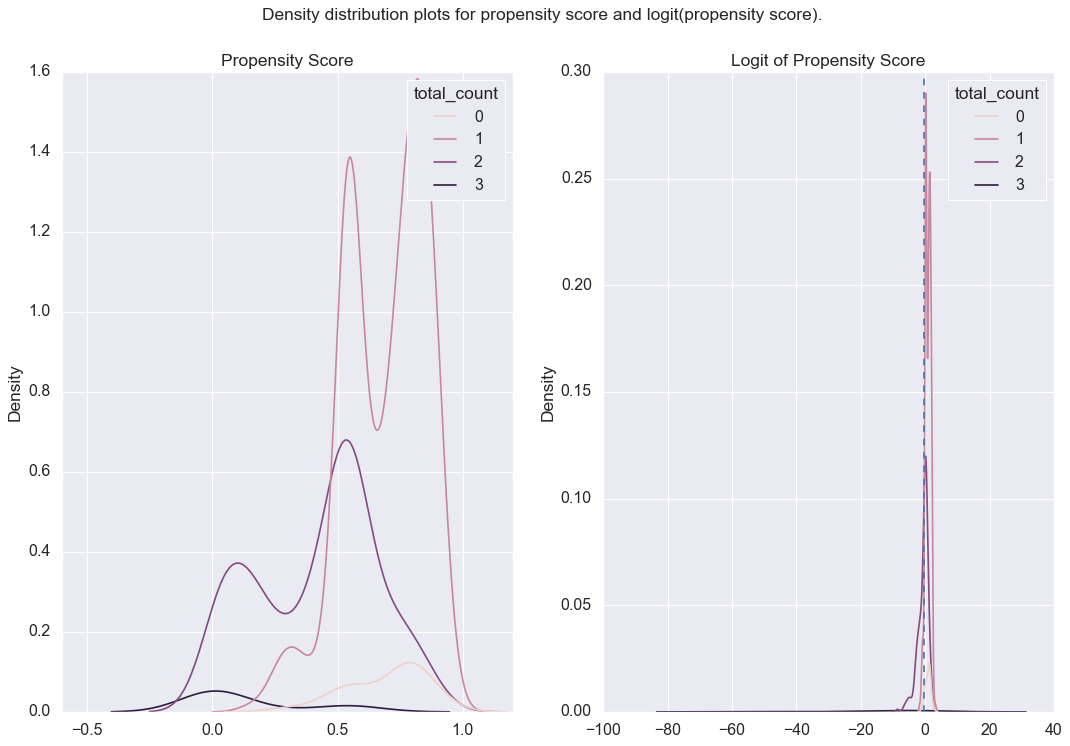


Caliper (radius) is: 0.0606

Spearman correlation: 0.1272316507494894 p-value: 0.00206561365488853
[[  0   0   0   0]
 [ 13   0   0   0]
 [  2  61   0   0]
 [ 25 282 200   0]]


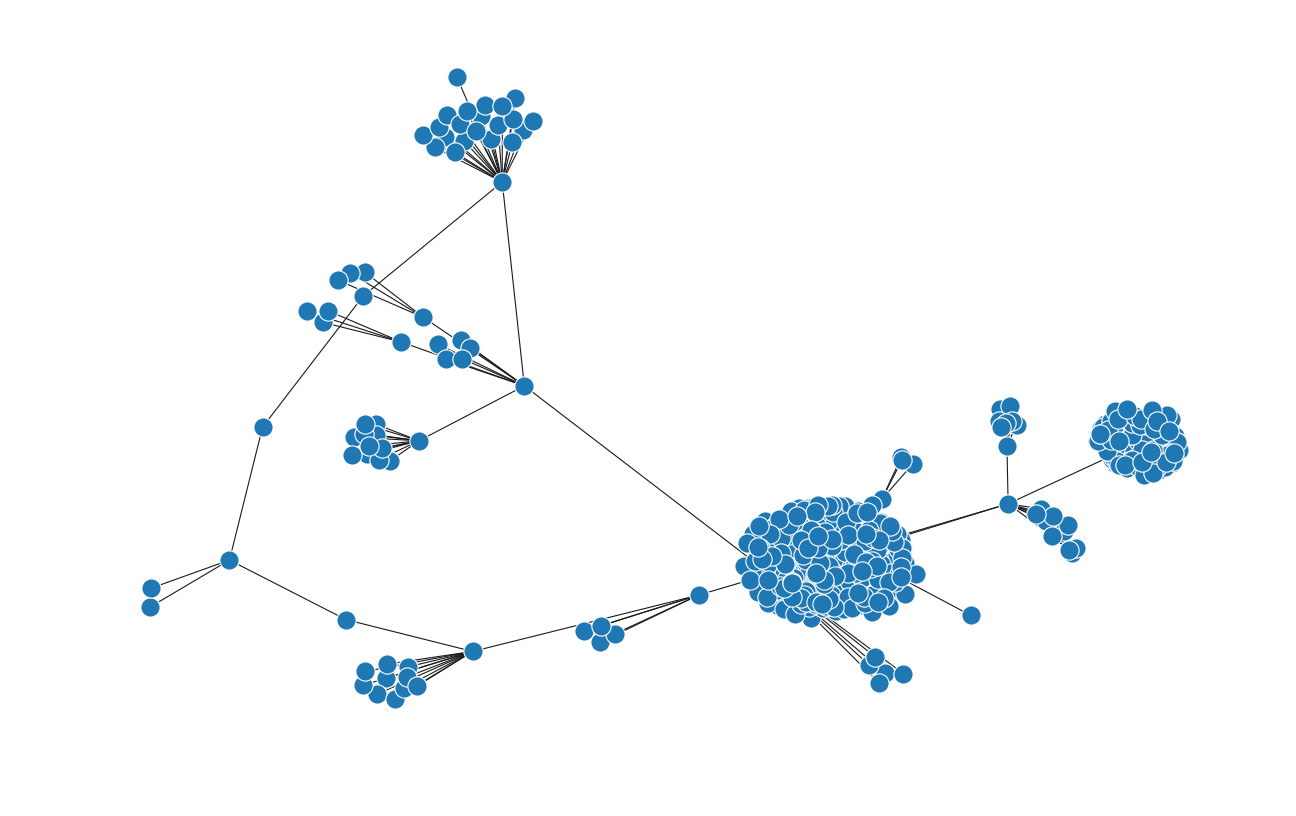

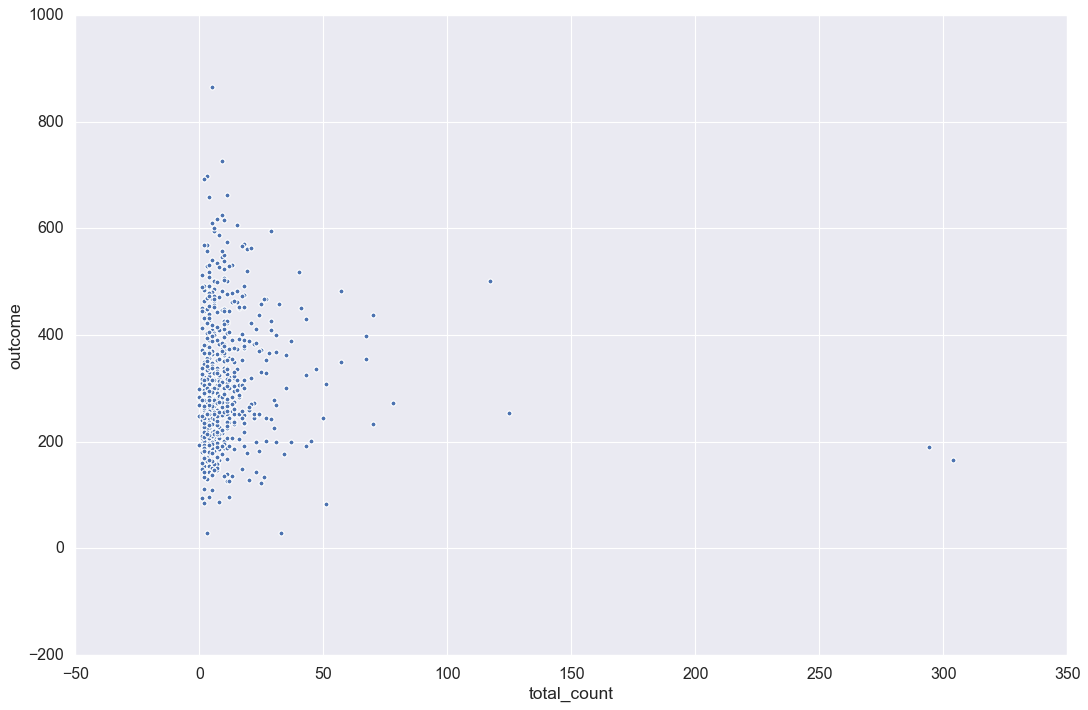

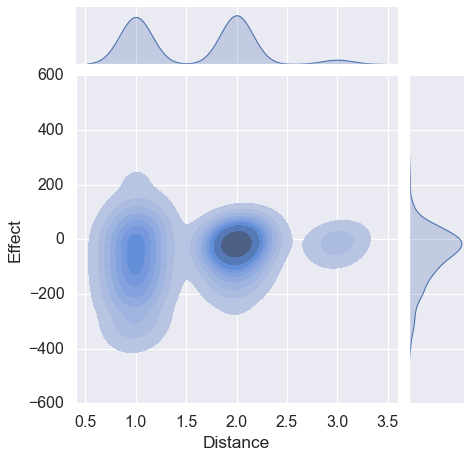

In [8]:
#2011 total

obtain_results(full_dataset_confounders_2011, 'total_count', all_columns_to_drop_year)

Accuracy: 0.7048

Confusion matrix:
[[  1  27   1   0]
 [  0 317  25   0]
 [  0 112  88   1]
 [  0   3   4   7]]

F1 score is: [0.06666667 0.79151061 0.55172414 0.63636364]


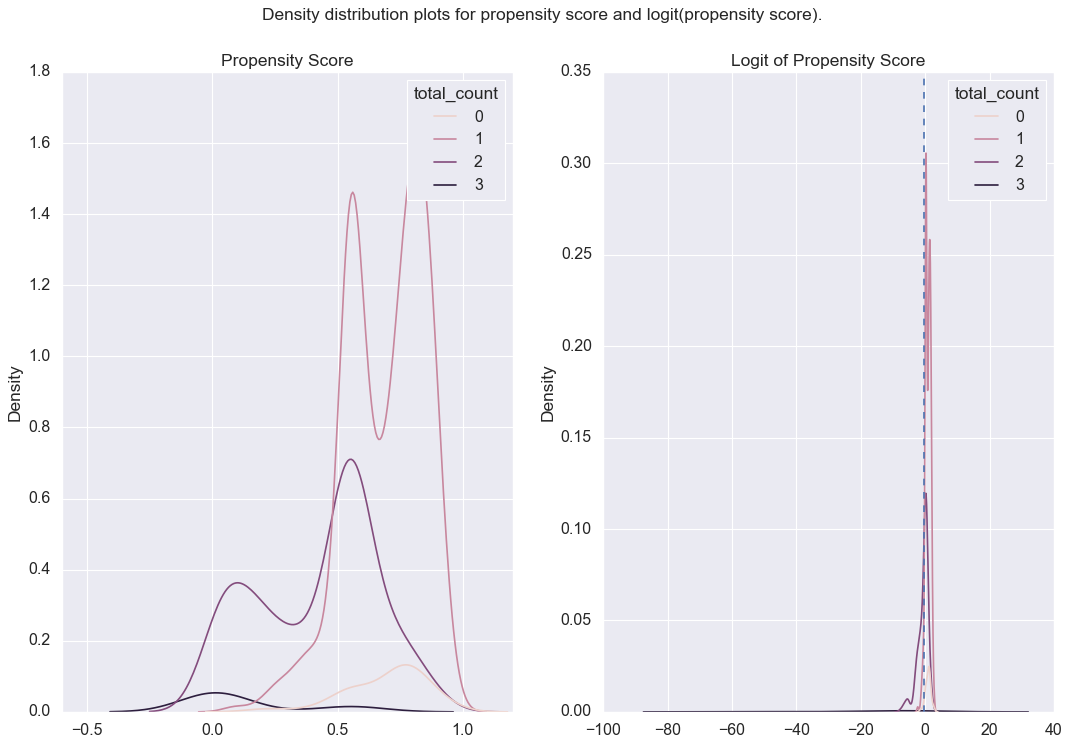


Caliper (radius) is: 0.0600

Spearman correlation: 0.14395516148079224 p-value: 0.00047305426668060413
[[  0   0   0   0]
 [ 12   0   0   0]
 [  2  62   0   0]
 [ 26 284 199   0]]


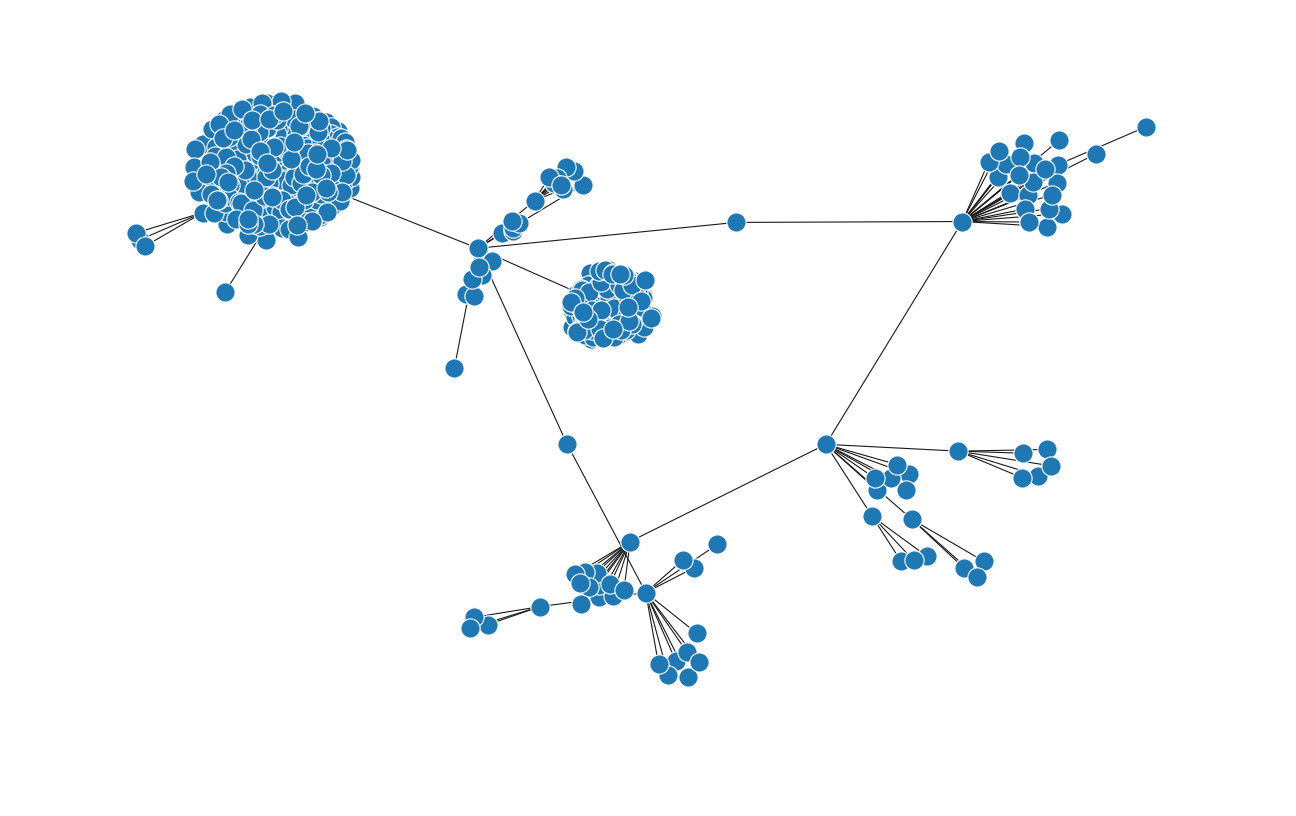

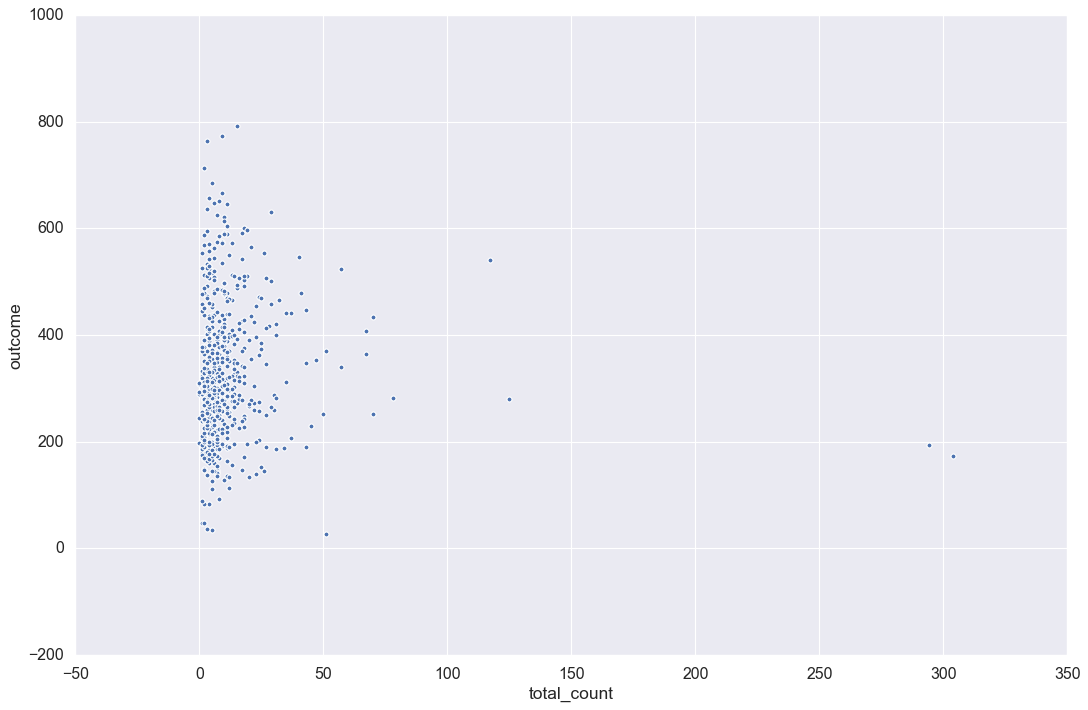

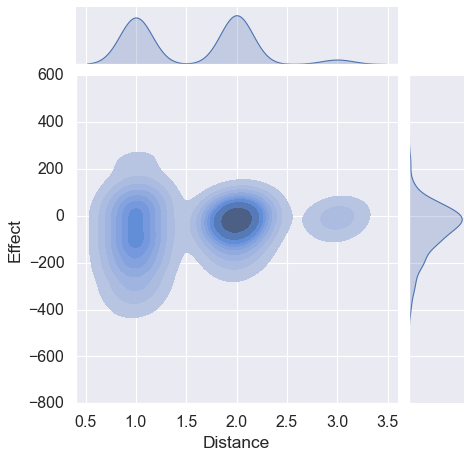

In [9]:
#2012 total

obtain_results(full_dataset_confounders_2012, 'total_count', all_columns_to_drop_year)

Accuracy: 0.7021

Confusion matrix:
[[  0  28   1   0]
 [  0 316  25   0]
 [  0 112  87   1]
 [  0   3   4   7]]

F1 score is: [0.         0.79       0.5488959  0.63636364]


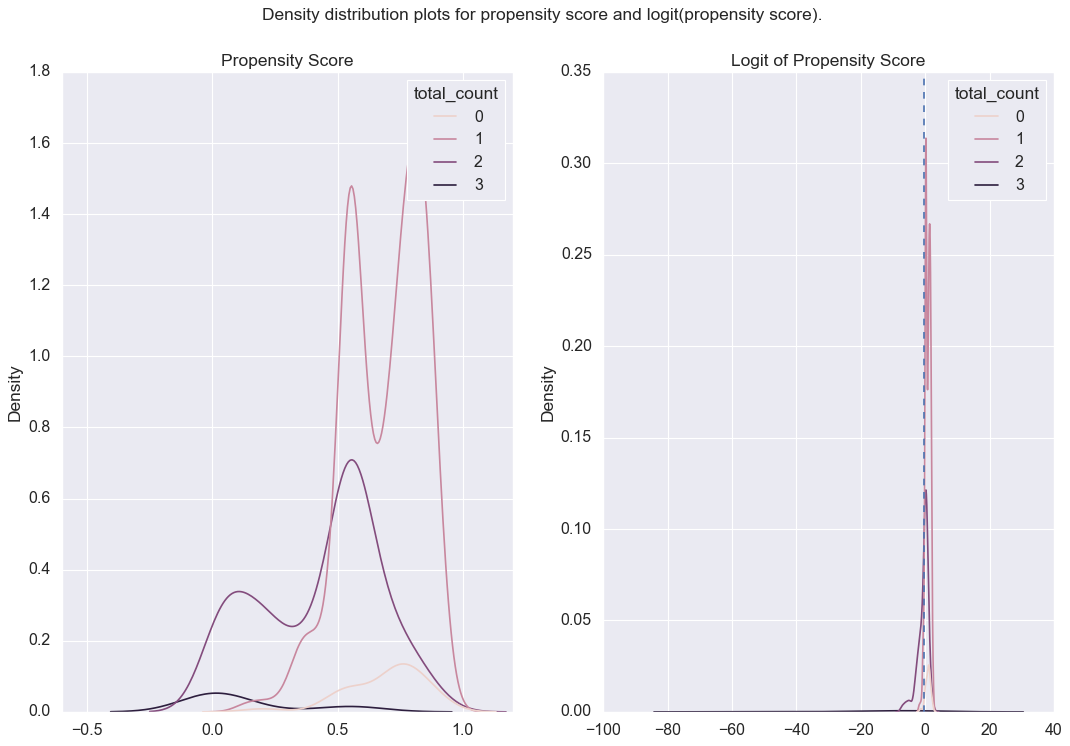


Caliper (radius) is: 0.0586

Spearman correlation: 0.13983092618200924 p-value: 0.0007025324246853539
[[  0   0   0   0]
 [  1   0   0   0]
 [  2  73   0   0]
 [ 26 283 198   0]]


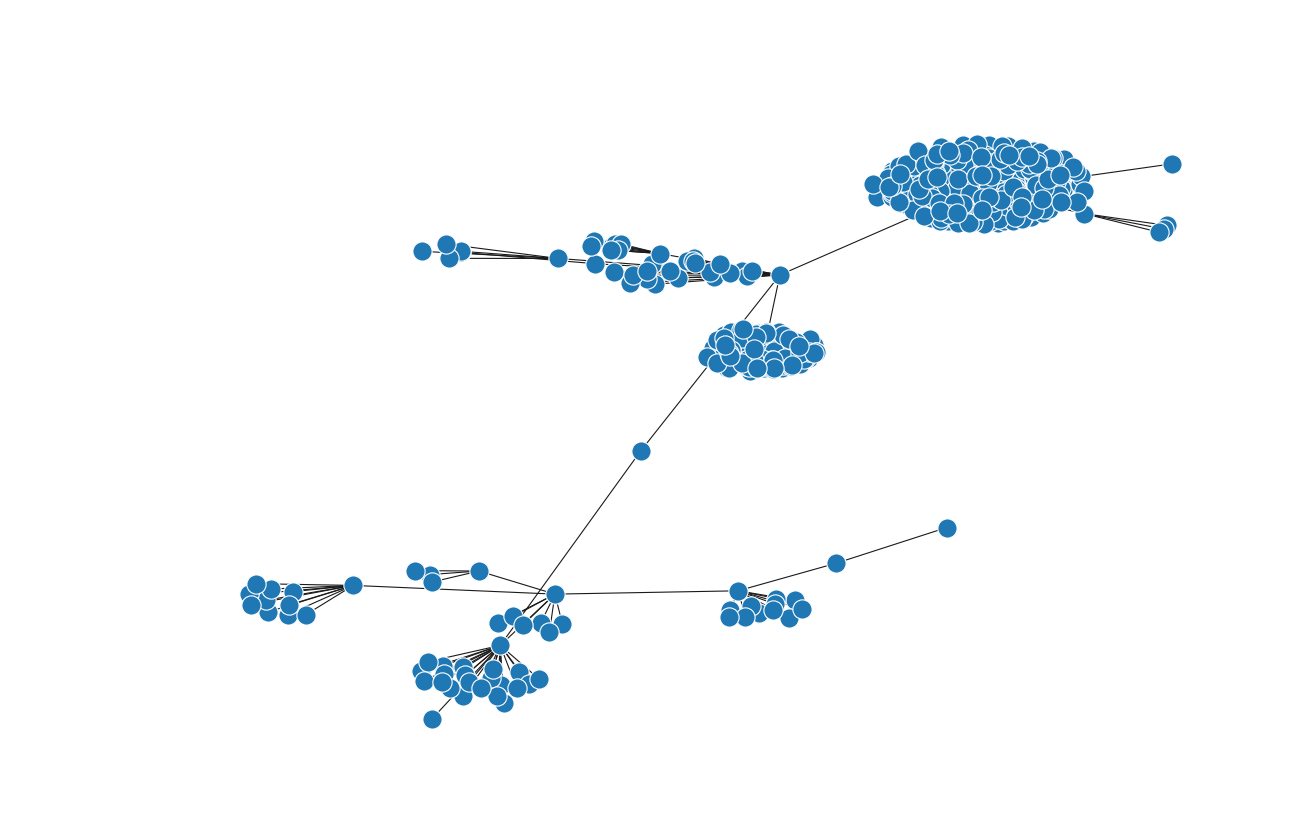

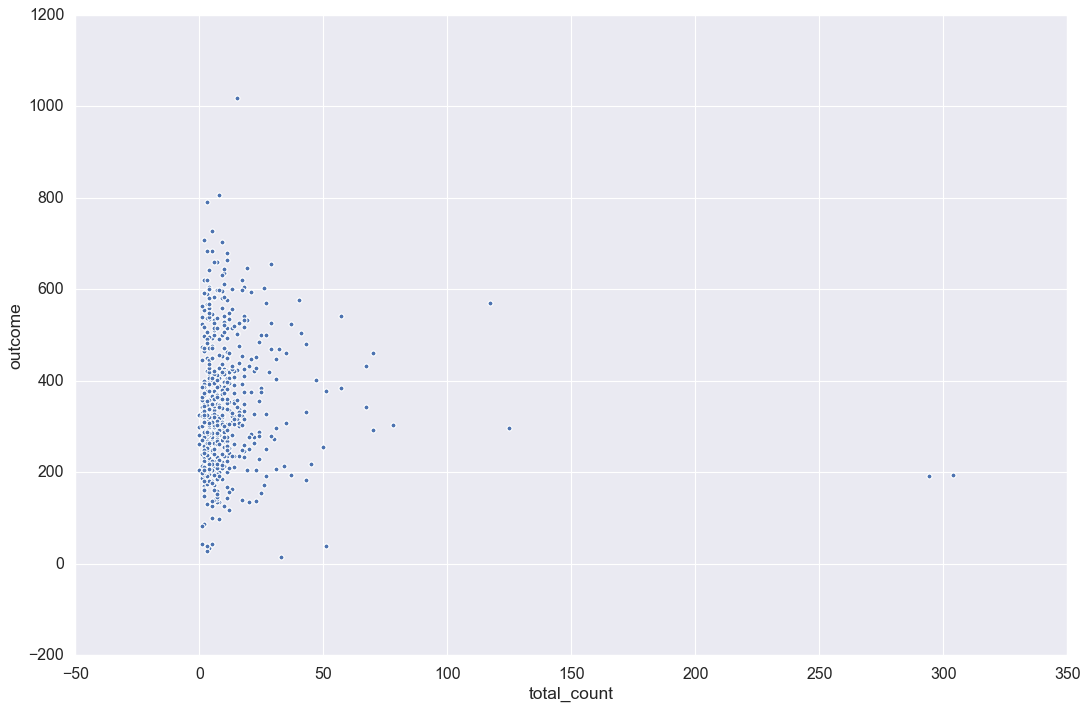

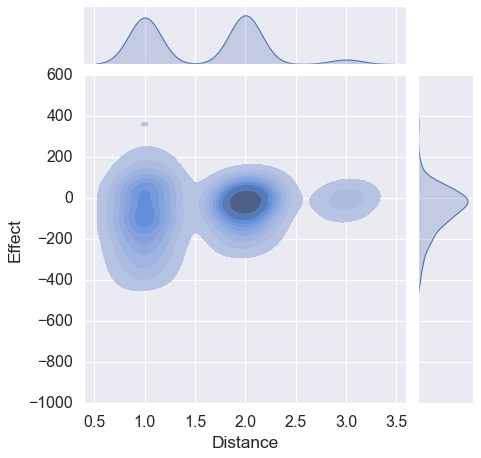

In [10]:
#2013 total

obtain_results(full_dataset_confounders_2013, 'total_count', all_columns_to_drop_year)

Accuracy: 0.9983

Confusion matrix:
[[583   0]
 [  1   0]]

F1 score is: [0.9991431 0.       ]


C:\Users\muize\AppData\Local\Temp\ipykernel_13908\1844548315.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
C:\Users\muize\AppData\Local\Temp\ipykernel_13908\1844548315.py:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])


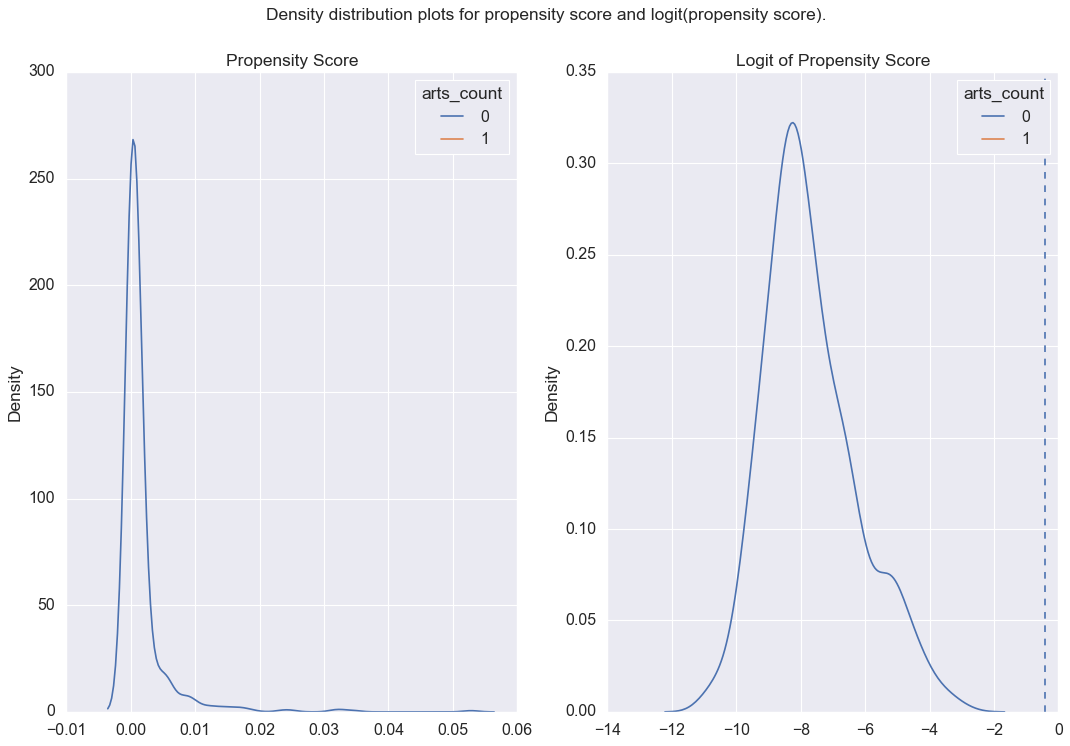

C:\Users\muize\AppData\Local\Temp\ipykernel_13908\1844548315.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'propensity_score'] = predictions[:,1]
C:\Users\muize\AppData\Local\Temp\ipykernel_13908\1844548315.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'propensity_score_logit'] = predictions_logit
C:\Users\muize\AppData\Local\Temp\ipykernel_13908\1844548315.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i


Caliper (radius) is: 0.0012

Spearman correlation: 0.02356005895116753 p-value: 0.5698899577419732
[[  0   0]
 [426   0]]


c:\Python310\lib\site-packages\seaborn\axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


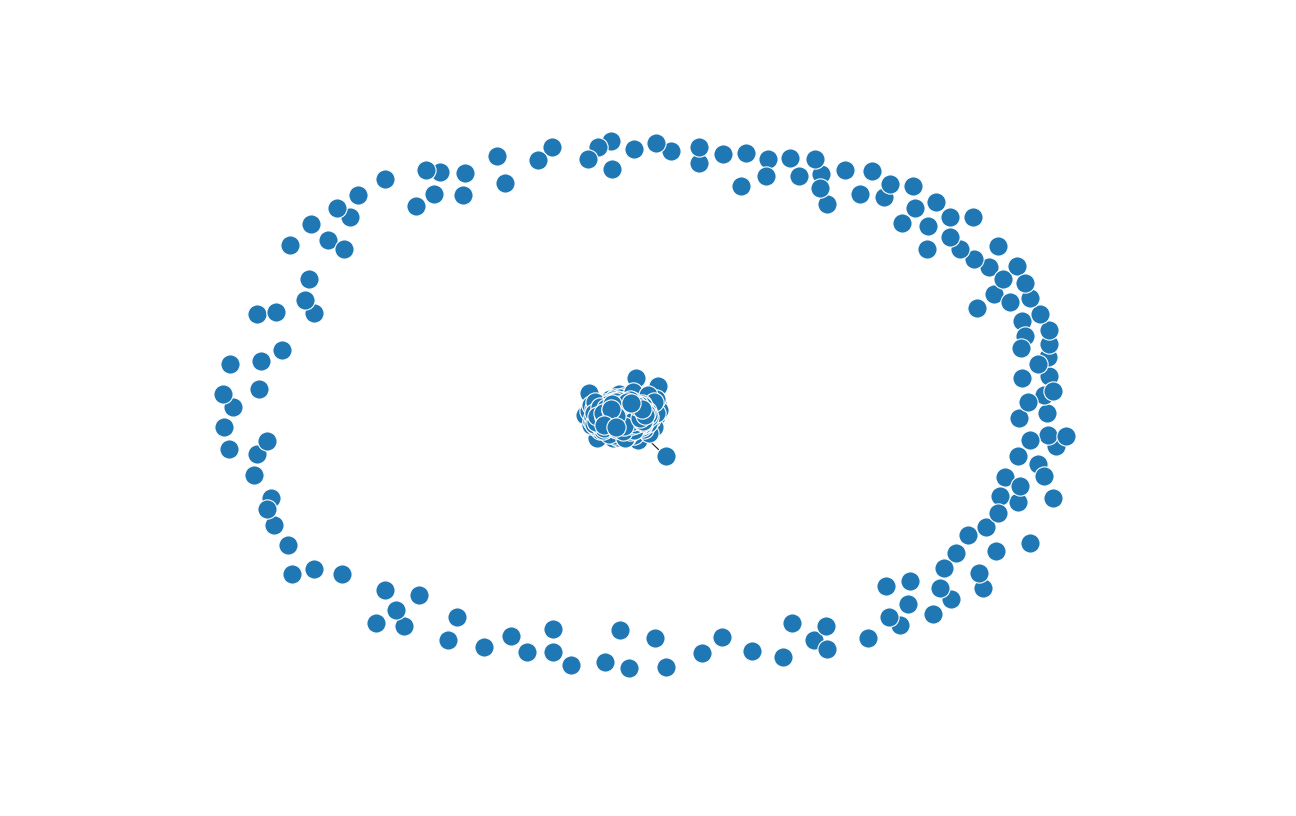

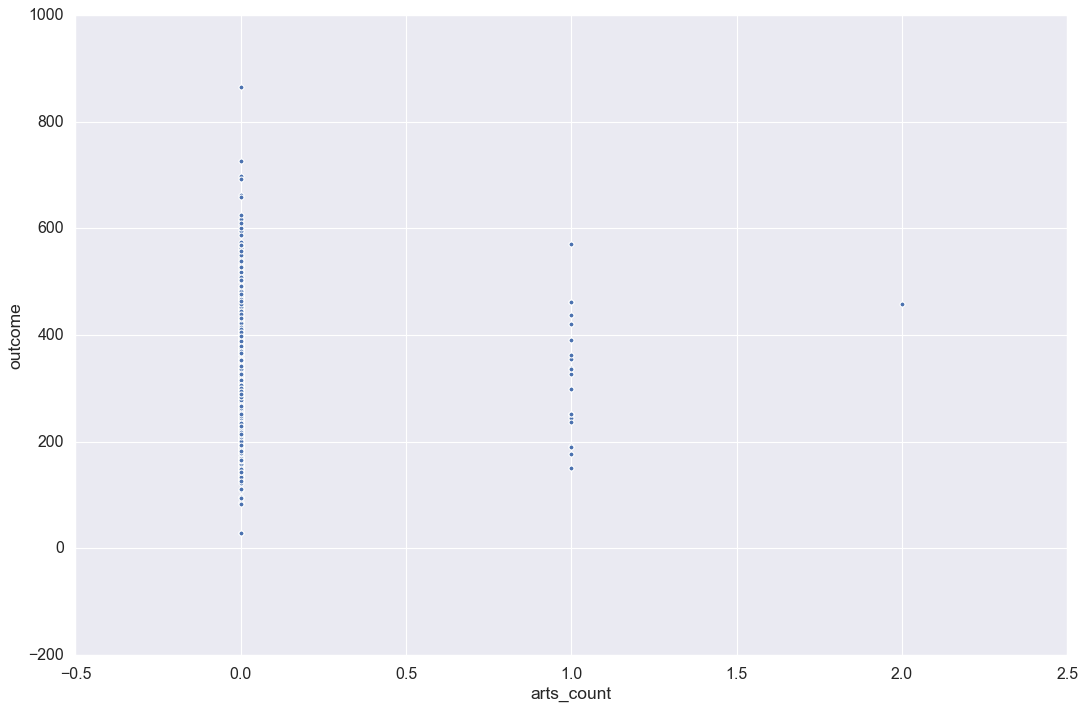

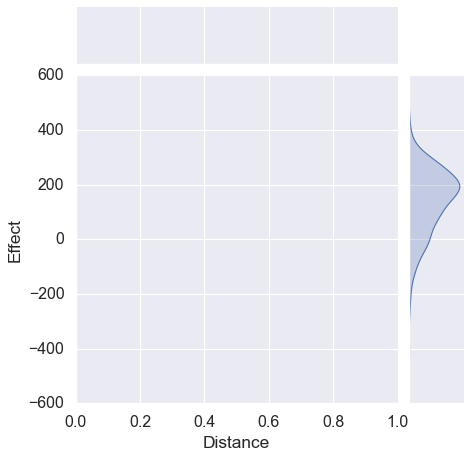

In [11]:
#2011 ARTS

obtain_results(full_dataset_confounders_2011, 'arts_count', all_columns_to_drop_arts)